# Natural Language Processing: Emotions Sentiment Analysis using TensorFlow with LSTM

## Install Kaggle and Config Kaggle

In [1]:
# Install Kaggle using pip
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nrahfi","key":"d590799ea549819d02256987601dbc43"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


## Download Dataset from Kaggle

In [4]:
# Download Dataset
!kaggle datasets download -d abdallahwagih/emotion-dataset

  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 112MB/s]


## Import Required Library

In [5]:
# Import Required Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import zipfile
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## Extract File Zip

In [6]:
# Extract File Zip
data_dir = "/content/"
zip_dir = f"{data_dir}/emotion-dataset.zip"
zip = zipfile.ZipFile(zip_dir, 'r')
zip.extractall('/content')
zip.close()

## Open File Dataset

In [7]:
# Open Dataset File
data = pd.read_csv(f"{data_dir}Emotion_classify_Data.csv")
data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


## Search Total Data, Total Null Values, and Total Duplicated Values

In [8]:
# Search Total Data, Total Null Values, and Total Duplicated Values
total_data = data.shape
null_data = data.isnull().sum()
duplicated_data  = data.duplicated()
print(f"Total Row & Column: \n{total_data}\n\nTotal null Values:\n{null_data}\n\nTotal duplicated Values:\n{duplicated_data}")

Total Row & Column: 
(5937, 2)

Total null Values:
Comment    0
Emotion    0
dtype: int64

Total duplicated Values:
0       False
1       False
2       False
3       False
4       False
        ...  
5932    False
5933    False
5934    False
5935    False
5936    False
Length: 5937, dtype: bool


## Count Emotions Value

In [9]:
data['Emotion'].value_counts()

Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

## Countplot Emotions

<Axes: xlabel='count', ylabel='Emotion'>

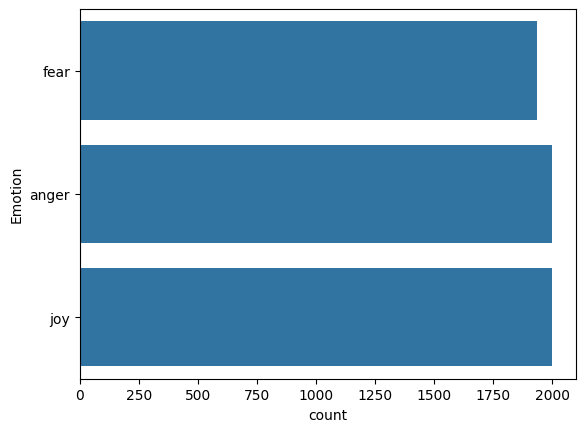

In [10]:
# Countplot Emotion
sb.countplot(data.Emotion)

## Import Another Required Library

In [11]:
# Import Required Library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.preprocessing import text, sequence
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Stopwords

In [12]:
stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

## Cleaning Text

In [13]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

stwd = stopwords.words('english')

def clean_text(text):

    cleaned_text = text
    cleaned_text = strip_html(cleaned_text)
    cleaned_text = remove_between_square_brackets(cleaned_text)
    cleaned_text = remove_url(cleaned_text)
    cleaned_text = remove_stopwords(cleaned_text)

    return cleaned_text

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stwd:
            final_text.append(word.strip())
    return " ".join(final_text)

data['Comment'] = data['Comment'].apply(clean_text)

In [14]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.Comment)
corpus[:10]

['seriously',
 'hate',
 'one',
 'subject',
 'death',
 'feel',
 'reluctant',
 'drop',
 'im',
 'full']

In [15]:
# Total Common Words
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'feel': 4047,
 'feeling': 1964,
 'like': 992,
 'im': 943,
 'little': 326,
 'really': 323,
 'know': 315,
 'time': 294,
 'get': 292,
 'want': 267}

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    cv = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_words = cv.transform(corpus)
    sum_words = bag_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Most Common Words Countplot

<Axes: >

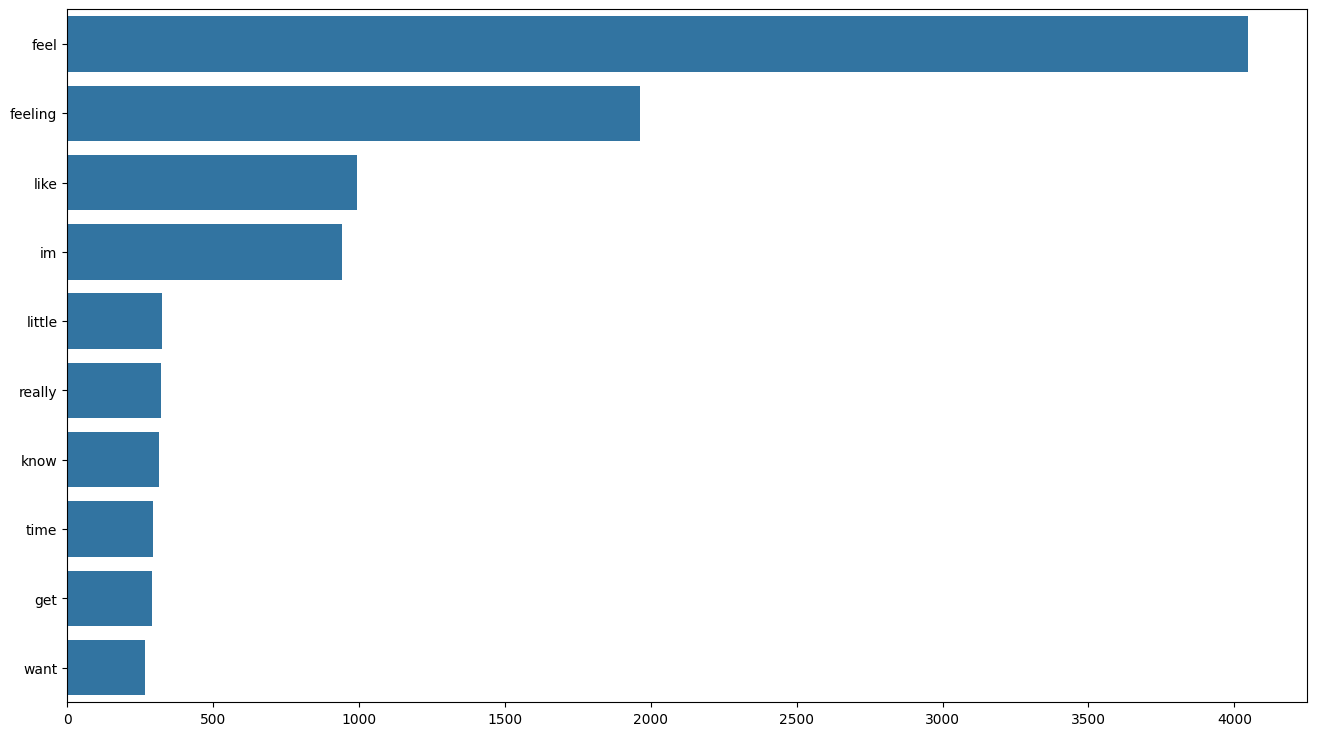

In [17]:
plt.figure(figsize = (16,9))
most_common = get_top_text_ngrams(data.Comment, 10, 1)
most_common = dict(most_common)
sb.barplot(x=list(most_common.values()),y=list(most_common.keys()))

## One-Hot Encoding

In [18]:
# Data Emotion One-Hot Encoding
emotion = pd.get_dummies(data.Emotion, dtype=int)
new_data = pd.concat([data, emotion], axis=1)
new_data = new_data.drop(columns='Emotion')
new_data.head(10)

,Comment,anger,fear,joy
0,seriously hate one subject death feel reluctan...,0,1,0
1,im full life feel appalled,1,0,0
2,sit write start dig feelings think afraid acce...,0,1,0
3,ive really angry r feel like idiot trusting fi...,0,0,1
4,feel suspicious one outside like rapture happe...,0,1,0
5,feel jealous becasue wanted kind love true con...,1,0,0
6,friend mine keeps telling morbid things happen...,1,0,0
7,finally fell asleep feeling angry useless stil...,1,0,0
8,feel bit annoyed antsy good way,1,0,0
9,feel like regained another vital part life living,0,0,1


In [19]:
new_data.columns

Index(['Comment', 'anger', 'fear', 'joy'], dtype='object')

In [20]:
datas = new_data['Comment'].values
emotions = new_data[['anger', 'fear', 'joy']].values

In [21]:
datas

array(['seriously hate one subject death feel reluctant drop',
       'im full life feel appalled',
       'sit write start dig feelings think afraid accept possibility might make',
       ...,
       'ever get married everything ready offer got together go clubs even perfect good looking guys feel intimated talking clever self',
       'feel reluctant applying want able find company know least one person',
       'wanted apologize feel like heartless bitch'], dtype=object)

In [22]:
emotions

array([[0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

## Tokenizer and Train Model

In [23]:
x_train,x_test,y_train,y_test = train_test_split(datas, emotions, test_size = 0.2, shuffle=True)

In [24]:
# Create Callback
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98 and logs.get('val_accuracy')> 0.92):
      print("Accuracy have been achieved!")
      self.model.stop_training = True
callbacks= Callback()

In [25]:
vocab_size = 5000
max_len = 200
trunc_type = "post"
oov_tok = "<oov>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           320000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1

In [27]:
history = model.fit(pad_train, y_train, epochs=50, validation_data=(pad_test, y_test), batch_size=64, verbose=2, callbacks=[callbacks])

Epoch 1/50
75/75 - 15s - loss: 1.0903 - accuracy: 0.3788 - val_loss: 1.0105 - val_accuracy: 0.6313 - 15s/epoch - 201ms/step
Epoch 2/50
75/75 - 6s - loss: 0.5719 - accuracy: 0.8052 - val_loss: 0.3258 - val_accuracy: 0.8897 - 6s/epoch - 81ms/step
Epoch 3/50
75/75 - 3s - loss: 0.1251 - accuracy: 0.9693 - val_loss: 0.2538 - val_accuracy: 0.9268 - 3s/epoch - 46ms/step
Epoch 4/50
75/75 - 3s - loss: 0.0629 - accuracy: 0.9859 - val_loss: 0.5186 - val_accuracy: 0.8670 - 3s/epoch - 38ms/step
Epoch 5/50
75/75 - 2s - loss: 0.0516 - accuracy: 0.9872 - val_loss: 0.3155 - val_accuracy: 0.9133 - 2s/epoch - 27ms/step
Epoch 6/50
75/75 - 2s - loss: 0.0269 - accuracy: 0.9937 - val_loss: 0.4163 - val_accuracy: 0.9074 - 2s/epoch - 23ms/step
Epoch 7/50
75/75 - 1s - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.4288 - val_accuracy: 0.9125 - 988ms/epoch - 13ms/step
Epoch 8/50
75/75 - 1s - loss: 0.0181 - accuracy: 0.9956 - val_loss: 0.4813 - val_accuracy: 0.9082 - 1s/epoch - 19ms/step
Epoch 9/50
75/75 - 2s - lo

## Modela Evaluation: Model Accuracy and Model Loss Plot

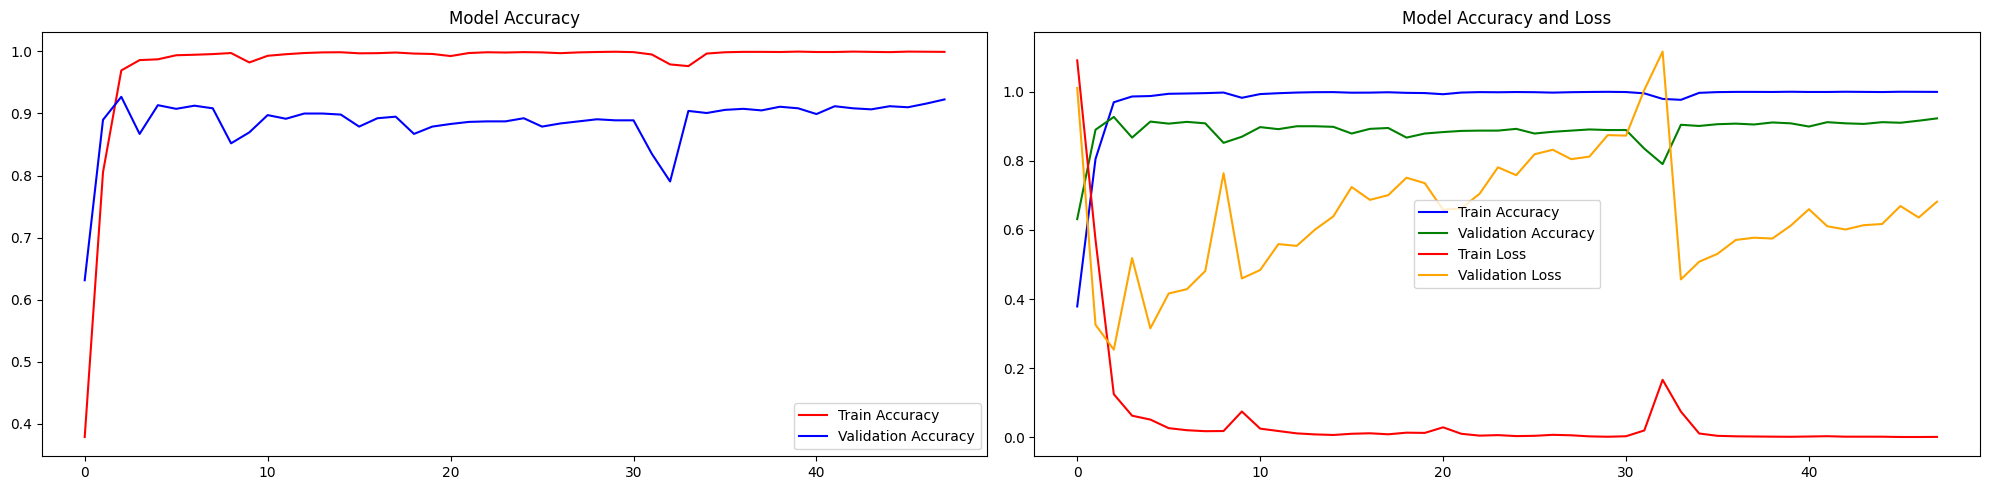

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Create a subplot figure
plt.figure(figsize=(20, 5))  # Adjust figure size as needed

# Subplot for Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend(loc=0)

# Subplot for all
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(epochs, acc, 'blue', label='Train Accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation Accuracy')
plt.plot(epochs, loss, 'red', label='Train Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Model Accuracy and Loss')
plt.legend(loc=0)


# Adjust layout to prevent overlapping elements
plt.tight_layout()

plt.show()